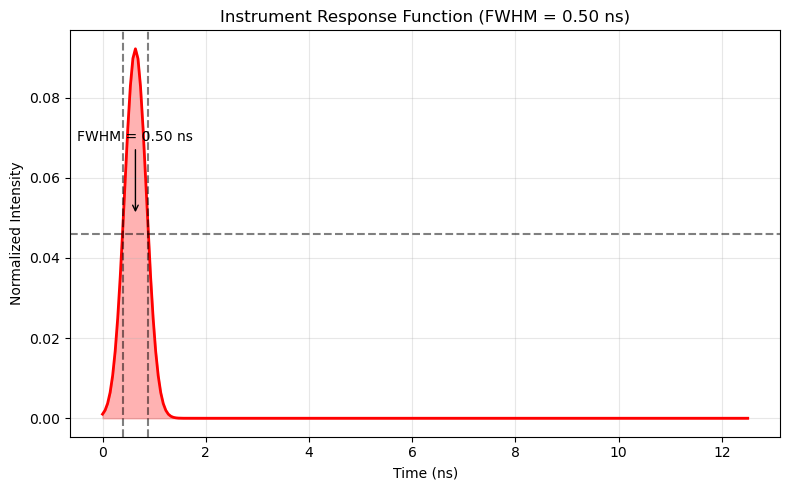

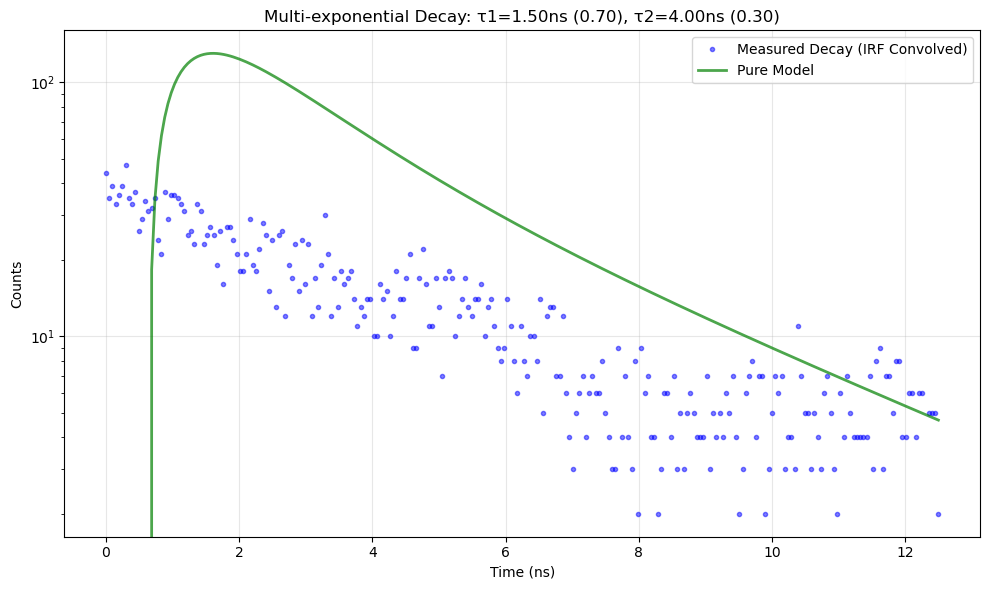

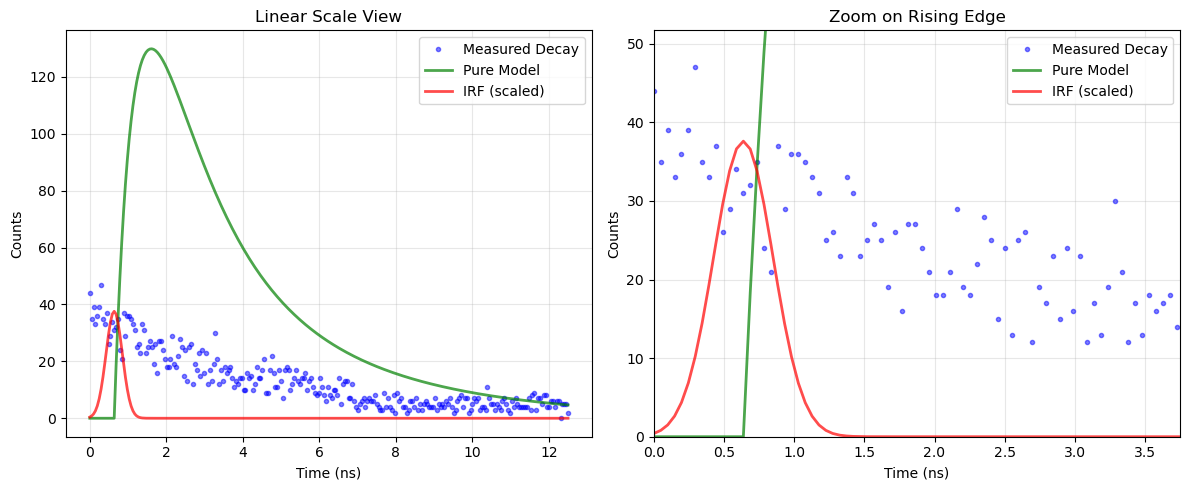

Lifetimes: [1.5, 4.0]
Amplitudes: [0.7, 0.3]
Amplitude-weighted average lifetime: 2.25 ns
IRF FWHM: 0.5 ns
Total photons detected: 3304


In [1]:
import numpy as np
from scipy.signal import convolve
import matplotlib.pyplot as plt

def simulate_multi_exponential_decay_with_irf(lifetimes, amplitudes, irf_fwhm, time_bins=256, 
                                             time_range=(0, 12.5), num_photons=10000, 
                                             background=0, rising_factor=1.0):
    """
    Simulate a multi-exponential fluorescence lifetime decay curve with a realistic IRF and rising component.
    
    Parameters:
    -----------
    lifetimes : list or array
        List of fluorescence lifetimes (in nanoseconds)
    amplitudes : list or array
        Relative amplitudes for each lifetime component (will be normalized)
    irf_fwhm : float
        Full Width at Half Maximum of the IRF (in nanoseconds)
    time_bins : int
        Number of time bins to use
    time_range : tuple
        (min_time, max_time) in nanoseconds
    num_photons : int
        Total number of photons to simulate
    background : float
        Expected background counts per bin
    rising_factor : float
        Controls the steepness of the rising edge. Higher values create a sharper rise
        
    Returns:
    --------
    times : numpy array
        Time points (center of bins) of the simulation
    decay_curve : numpy array
        Simulated decay curve including IRF and rising component
    irf : numpy array
        The generated IRF (Gaussian)
    pure_decay : numpy array
        The pure exponential decay before convolution
    """
    min_time, max_time = time_range
    
    # Verify inputs
    if len(lifetimes) != len(amplitudes):
        raise ValueError("The number of lifetimes must match the number of amplitudes")
    
    # Normalize amplitudes to sum to 1
    norm_amplitudes = np.array(amplitudes) / np.sum(amplitudes)
    
    # Create time axis
    times = np.linspace(min_time, max_time, time_bins)
    dt = times[1] - times[0]  # Time step
    
    # Create IRF (Gaussian)
    # Convert FWHM to standard deviation: FWHM = 2.35482 * sigma
    sigma = irf_fwhm / 2.35482
    # Center the IRF at about 3 * sigma from the left edge to see the full peak
    center_position = min_time + 3 * sigma
    irf = np.exp(-0.5 * ((times - center_position) / sigma)**2)
    irf = irf / np.sum(irf)  # Normalize IRF
    
    # Create pure multi-exponential decay
    pure_decay = np.zeros_like(times)
    decay_start_idx = np.argmin(np.abs(times - center_position))
    decay_times = times[decay_start_idx:] - times[decay_start_idx]
    
    # For rising edge modeling
    rise_time = min(lifetimes) / rising_factor  # Use the shortest lifetime for rise time scaling
    rising_component = 1 - np.exp(-decay_times / rise_time)
    
    # Build multi-exponential model with each lifetime component
    multi_exp_decay = np.zeros_like(decay_times)
    
    for i, (lifetime, amplitude) in enumerate(zip(lifetimes, norm_amplitudes)):
        # Individual exponential decay for this component
        decay_component = amplitude * np.exp(-decay_times / lifetime)
        multi_exp_decay += decay_component
    
    # Apply rising component to the entire multi-exponential decay
    modeled_curve = rising_component * multi_exp_decay
    
    # Assign to the pure decay array
    pure_decay[decay_start_idx:] = modeled_curve
    
    # Normalize to desired number of photons
    if np.sum(pure_decay) > 0:  # Avoid division by zero
        pure_decay = pure_decay * (num_photons / np.sum(pure_decay))
    
    # Convolve with IRF
    decay_curve = convolve(pure_decay, irf, mode='same')
    
    # Add Poisson noise to simulate photon counting
    decay_curve = np.random.poisson(decay_curve)
    
    # Add random background if specified
    if background > 0:
        bg_counts = np.random.poisson(background, size=time_bins)
        decay_curve = decay_curve + bg_counts
    
    return times, decay_curve, irf, pure_decay

def plot_multi_exponential_decay_enhanced(times, decay_curve, irf, pure_decay, lifetimes, amplitudes, irf_fwhm):
    """
    Create enhanced plots for visualizing the multi-exponential decay curve, IRF, and pure decay separately.
    
    Parameters:
    -----------
    times : numpy array
        Time points
    decay_curve : numpy array
        Simulated decay curve including IRF and photon noise
    irf : numpy array
        The generated IRF
    pure_decay : numpy array
        The pure model before convolution
    lifetimes : list or array
        The lifetimes used for simulation
    amplitudes : list or array
        The amplitudes used for simulation
    irf_fwhm : float
        FWHM of the IRF used
        
    Returns:
    --------
    figs : list
        List of figure objects
    """
    figs = []
    
    # Figure 1: IRF visualization
    fig1, ax1 = plt.subplots(figsize=(8, 5))
    ax1.plot(times, irf, 'r-', linewidth=2)
    ax1.fill_between(times, 0, irf, color='red', alpha=0.3)
    ax1.set_xlabel('Time (ns)')
    ax1.set_ylabel('Normalized Intensity')
    ax1.set_title(f'Instrument Response Function (FWHM = {irf_fwhm:.2f} ns)')
    
    # Add FWHM indicators
    max_irf = np.max(irf)
    half_max = max_irf / 2
    
    # Find where IRF crosses half-max
    above_half_max = irf >= half_max
    if np.any(above_half_max):
        indices = np.where(above_half_max)[0]
        left_idx = indices[0]
        right_idx = indices[-1]
        
        left_x = times[left_idx]
        right_x = times[right_idx]
        
        # Draw horizontal line at half max
        ax1.axhline(y=half_max, color='k', linestyle='--', alpha=0.5)
        
        # Draw vertical lines at FWHM points
        ax1.axvline(x=left_x, color='k', linestyle='--', alpha=0.5)
        ax1.axvline(x=right_x, color='k', linestyle='--', alpha=0.5)
        
        # Label the FWHM
        ax1.annotate(f'FWHM = {irf_fwhm:.2f} ns', 
                   xy=((left_x + right_x)/2, half_max*1.1),
                   xytext=((left_x + right_x)/2, half_max*1.5),
                   arrowprops=dict(arrowstyle="->", connectionstyle="arc3"),
                   ha='center')
    
    ax1.grid(True, alpha=0.3)
    plt.tight_layout()
    figs.append(fig1)
    
    # Figure 2: Pure Decay vs IRF-Convolved Decay (log scale)
    fig2, ax2 = plt.subplots(figsize=(10, 6))
    
    # Plot components
    ax2.plot(times, decay_curve, 'b.', alpha=0.5, label='Measured Decay (IRF Convolved)')
    ax2.plot(times, pure_decay, 'g-', linewidth=2, alpha=0.7, label='Pure Model')
    
    # Create title with lifetime components
    title = f'Multi-exponential Decay: '
    for i, (tau, amp) in enumerate(zip(lifetimes, amplitudes)):
        # Add each component to the title
        if i > 0:
            title += ", "
        # Format with normalized amplitude
        norm_amp = amp / sum(amplitudes)
        title += f'τ{i+1}={tau:.2f}ns ({norm_amp:.2f})'
    
    ax2.set_xlabel('Time (ns)')
    ax2.set_ylabel('Counts')
    ax2.set_title(title)
    ax2.set_yscale('log')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    plt.tight_layout()
    figs.append(fig2)
    
    # Figure 3: All components in linear scale with zoom-in to early times
    fig3, (ax3a, ax3b) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Scale IRF for visibility in the main plot
    irf_max = np.max(decay_curve) * 0.8
    irf_scaled = irf * (irf_max / np.max(irf)) if np.max(irf) > 0 else irf
    
    # Main plot - Linear scale with all components
    ax3a.plot(times, decay_curve, 'b.', alpha=0.5, label='Measured Decay')
    ax3a.plot(times, pure_decay, 'g-', linewidth=2, alpha=0.7, label='Pure Model')
    ax3a.plot(times, irf_scaled, 'r-', linewidth=2, alpha=0.7, label='IRF (scaled)')
    ax3a.set_xlabel('Time (ns)')
    ax3a.set_ylabel('Counts')
    ax3a.set_title('Linear Scale View')
    ax3a.legend()
    ax3a.grid(True, alpha=0.3)
    
    # Zoom-in on early times to see rising edge and IRF clearly
    # Find a reasonable range for zooming (first 20% of the time range + some padding)
    zoom_end_idx = int(len(times) * 0.2)
    zoom_end_time = times[zoom_end_idx]
    
    # Identify the peak of the decay curve for setting y-limit
    peak_idx = np.argmax(decay_curve[:zoom_end_idx*2])
    peak_value = decay_curve[peak_idx]
    
    ax3b.plot(times, decay_curve, 'b.', alpha=0.5, label='Measured Decay')
    ax3b.plot(times, pure_decay, 'g-', linewidth=2, alpha=0.7, label='Pure Model')
    ax3b.plot(times, irf_scaled, 'r-', linewidth=2, alpha=0.7, label='IRF (scaled)')
    
    # Set zoom limits
    ax3b.set_xlim(0, zoom_end_time * 1.5)  # Add some padding
    ax3b.set_ylim(0, peak_value * 1.1)      # Add some headroom
    
    ax3b.set_xlabel('Time (ns)')
    ax3b.set_ylabel('Counts')
    ax3b.set_title('Zoom on Rising Edge')
    ax3b.legend()
    ax3b.grid(True, alpha=0.3)
    
    plt.tight_layout()
    figs.append(fig3)
    
    return figs

def calculate_average_lifetime(lifetimes, amplitudes):
    """
    Calculate amplitude-weighted average lifetime for a multi-exponential decay.
    
    Parameters:
    -----------
    lifetimes : list or array
        List of lifetimes (in nanoseconds)
    amplitudes : list or array
        List of corresponding amplitudes
        
    Returns:
    --------
    avg_lifetime : float
        Amplitude-weighted average lifetime
    """
    # Normalize amplitudes
    norm_amplitudes = np.array(amplitudes) / np.sum(amplitudes)
    
    # Calculate amplitude-weighted average
    avg_lifetime = np.sum(np.array(lifetimes) * norm_amplitudes)
    
    return avg_lifetime

# Example usage
if __name__ == "__main__":
    # Parameters for multi-exponential decay
    lifetimes = [1.5, 4.0]  # Two lifetime components (in nanoseconds)
    amplitudes = [0.7, 0.3]  # 70% first component, 30% second component
    
    irf_fwhm = 0.5  # nanoseconds
    time_bins = 256
    time_range = (0, 12.5)  # nanoseconds
    num_photons = 10000
    background_level = 5  # average background counts per bin
    rising_factor = 2.0  # controls how quickly the signal rises
    
    # Simulate multi-exponential decay curve
    times, decay_curve, irf, pure_decay = simulate_multi_exponential_decay_with_irf(
        lifetimes=lifetimes,
        amplitudes=amplitudes,
        irf_fwhm=irf_fwhm,
        time_bins=time_bins,
        time_range=time_range,
        num_photons=num_photons,
        background=background_level,
        rising_factor=rising_factor
    )
    
    # Generate enhanced plots
    figs = plot_multi_exponential_decay_enhanced(
        times=times,
        decay_curve=decay_curve,
        irf=irf,
        pure_decay=pure_decay,
        lifetimes=lifetimes,
        amplitudes=amplitudes,
        irf_fwhm=irf_fwhm
    )
    
    # Show all plots
    plt.show()
    
    # Calculate average lifetime
    avg_lifetime = calculate_average_lifetime(lifetimes, amplitudes)
    
    # Calculate total photons
    total_photons = np.sum(decay_curve)
    
    print(f"Lifetimes: {lifetimes}")
    print(f"Amplitudes: {amplitudes}")
    print(f"Amplitude-weighted average lifetime: {avg_lifetime:.2f} ns")
    print(f"IRF FWHM: {irf_fwhm} ns")
    print(f"Total photons detected: {total_photons}")

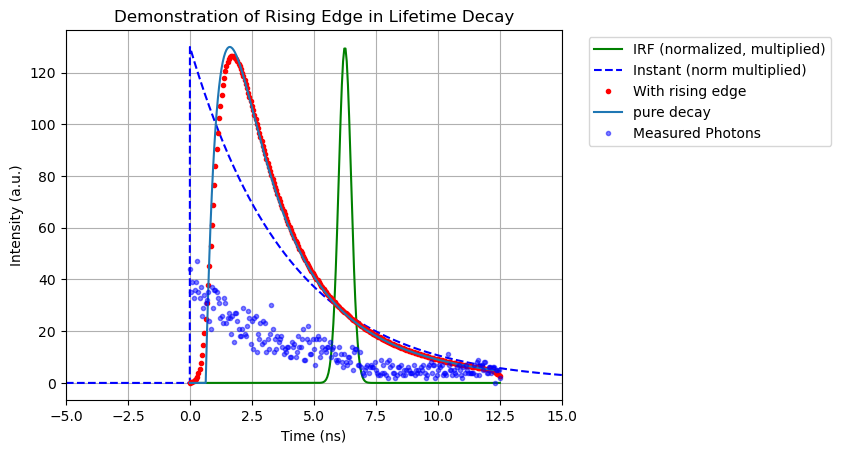

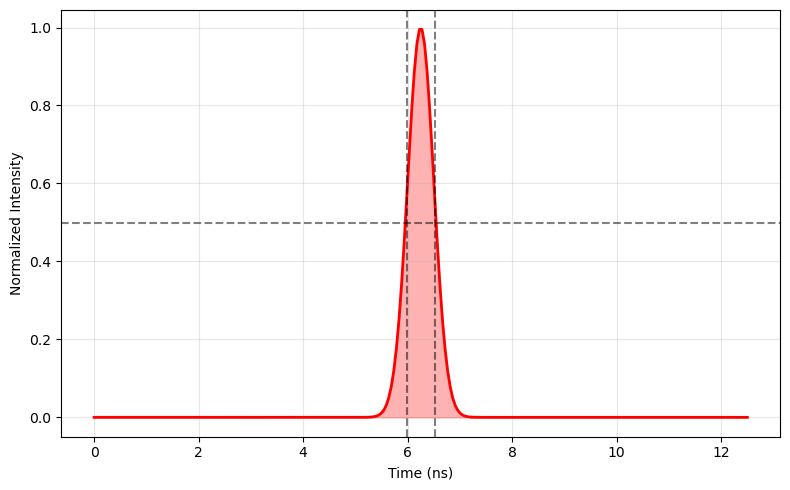

In [2]:
import numpy as np
from scipy import signal

def add_rising_edge(time, existing_decay, irf):
    """
    Adds a realistic rising edge to an existing exponential decay model
    by convolving it with an instrument response function (IRF).
    
    Parameters:
    -----------
    time : numpy.ndarray
        Time axis array (in nanoseconds or other consistent units)
    existing_decay : numpy.ndarray
        Existing exponential decay model with the same length as time
    irf : numpy.ndarray
        Instrument response function with the same length as time
    
    Returns:
    --------
    numpy.ndarray
        Modified decay curve with realistic rising edge
    """
    # Ensure inputs are numpy arrays
    time = np.asarray(time)
    existing_decay = np.asarray(existing_decay)
    irf = np.asarray(irf)
    
    # Normalize the IRF to preserve the intensity after convolution
    irf_normalized = irf / np.sum(irf)
    
    # Convolve the IRF with the existing decay model
    # mode='same' keeps the output array the same size as input
    convolved_signal = signal.convolve(existing_decay, irf_normalized, mode='same')
    
    # Scale the convolved signal to maintain the original amplitude
    # This step is optional depending on whether you want to preserve the peak intensity
    #scaling_factor = np.max(existing_decay) / np.max(convolved_signal)
    #print(scaling_factor)
    #convolved_signal = convolved_signal * scaling_factor
    
    return convolved_signal

def shift_decay_for_convolution(time, existing_decay, shift_amount):
    """
    Shifts an existing decay model to ensure proper alignment with the IRF
    before convolution. This is useful when the original decay starts at t=0
    but needs to be shifted to align with the IRF peak.
    
    Parameters:
    -----------
    time : numpy.ndarray
        Time axis array
    existing_decay : numpy.ndarray
        Existing exponential decay model
    shift_amount : float
        Amount to shift the decay (positive shifts right, negative shifts left)
    
    Returns:
    --------
    numpy.ndarray
        Shifted decay model
    """
    # Create an interpolation function for the existing decay
    from scipy.interpolate import interp1d
    
    # Extend the range slightly to handle edge effects
    f = interp1d(time, existing_decay, bounds_error=False, fill_value=0)
    
    # Create shifted time points
    shifted_time = time - shift_amount
    
    # Get values at shifted time points
    shifted_decay = f(shifted_time)
    
    return shifted_decay

def align_and_add_rising_edge(time, existing_decay, irf, t0=None):
    """
    Aligns the decay model with the IRF, then adds the rising edge.
    
    Parameters:
    -----------
    time : numpy.ndarray
        Time axis array
    existing_decay : numpy.ndarray
        Existing exponential decay model
    irf : numpy.ndarray
        Instrument response function
    t0 : float, optional
        Time zero position. If None, uses the peak of the IRF
    
    Returns:
    --------
    numpy.ndarray
        Properly aligned decay model with rising edge
    """
    # Find t0 from IRF if not provided
    if t0 is None:
        irf_peak_idx = np.argmax(irf)
        t0 = time[irf_peak_idx]
    
    # Find where the existing decay starts (assuming it's an ideal exponential)
    decay_start_idx = np.where(existing_decay > 0.001 * np.max(existing_decay))[0][0]
    decay_start_time = time[decay_start_idx]
    
    # Calculate shift amount needed
    shift_amount = decay_start_time - t0
    
    # Shift the decay if needed
    if abs(shift_amount) > 1e-10:
        shifted_decay = shift_decay_for_convolution(time, existing_decay, shift_amount)
    else:
        shifted_decay = existing_decay
    
    # Add the rising edge via convolution
    decay_with_rising_edge = add_rising_edge(time, shifted_decay, irf)
    
    return decay_with_rising_edge

import numpy as np
import matplotlib.pyplot as plt

# Create example data with finer time resolution around the rising edge
time = np.linspace(-5, 20, 5000)  # Time range in ns with more points

# Create a pure exponential decay (starts instantly at t=0)
tau = 4.0  # Lifetime in ns
ideal_decay = np.zeros_like(time)
ideal_decay[time >= 0] = np.exp(-time[time >= 0] / tau)

irf_width = 0.25  # Width in ns 
irf_center = 6.25  # Center the IRF 
irf = np.exp(-(times-irf_center)**2 / (2*irf_width**2))

# Add rising edge to the decay using our function
#realistic_decay = add_rising_edge(time, ideal_decay, irf)
realistic_decay = add_rising_edge(times,pure_decay,irf)
#realistic_decay = add_rising_edge(time,decay_curve,irf)

# Plot results
fulltime = []
plt.plot(times, irf*np.max(pure_decay), 'g-', label='IRF (normalized, multiplied)')
plt.plot(time, ideal_decay*np.max(pure_decay), 'b--', label='Instant (norm multiplied)')
plt.plot(times, realistic_decay, 'r.', label='With rising edge')
plt.plot(times,pure_decay,label='pure decay')
plt.plot(times, decay_curve, 'b.', alpha=0.5, label='Measured Photons')
plt.xlim([-5, 15])
plt.xlabel('Time (ns)')
plt.ylabel('Intensity (a.u.)')
plt.title('Demonstration of Rising Edge in Lifetime Decay')
plt.legend(loc='upper left', bbox_to_anchor=(1.04,1))
plt.grid(True)


fig1, ax1 = plt.subplots(figsize=(8, 5))
ax1.plot(times, irf, 'r-', linewidth=2)
ax1.fill_between(times, 0, irf, color='red', alpha=0.3)
ax1.set_xlabel('Time (ns)')
ax1.set_ylabel('Normalized Intensity')

# Add FWHM indicators
max_irf = np.max(irf)
half_max = max_irf / 2

# Find where IRF crosses half-max
above_half_max = irf >= half_max
if np.any(above_half_max):
    indices = np.where(above_half_max)[0]
    left_idx = indices[0]
    right_idx = indices[-1]
    
    left_x = times[left_idx]
    right_x = times[right_idx]
    
    # Draw horizontal line at half max
    ax1.axhline(y=half_max, color='k', linestyle='--', alpha=0.5)
    
    # Draw vertical lines at FWHM points
    ax1.axvline(x=left_x, color='k', linestyle='--', alpha=0.5)
    ax1.axvline(x=right_x, color='k', linestyle='--', alpha=0.5)
    
    

ax1.grid(True, alpha=0.3)
plt.tight_layout()

#plt.scatter(np.arange(1,1+len(realistic_decay)),realistic_decay)

